<a href="https://colab.research.google.com/github/anujdutt9/Deep-Learning-TF-2.0/blob/master/TF_2_CNN_EMNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMNIST Classification using CNN

In this notebook, we'll create a Convolutional Neural Network Model for classifying EMNIST [Extended MNIST] dataset consisting of digits as well as characters in English Language.

In [1]:
# Import Dependencies
%tensorflow_version 2.1
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
# Download the Dataset with the split 80% Training, 20% Validation
(train_data, validation_data), info = tfds.load('emnist/balanced',
                                          split=['train[:80%]','train[80%:]'],
                                          with_info=True,
                                          as_supervised=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/emnist/balanced/3.0.0.incompleteKJ14BA/emnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/emnist/balanced/3.0.0.incompleteKJ14BA/emnist-test.tfrecord


Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/balanced/3.0.0. Subsequent calls will reuse this data.


In [3]:
# Check Dataset Downloaded Files
!ls /root/tensorflow_datasets/emnist/balanced/3.0.0

dataset_info.json		     emnist-train.tfrecord-00000-of-00001
emnist-test.tfrecord-00000-of-00001  image.image.json


# Inspect the Downloaded Dataset

In [4]:
info

tfds.core.DatasetInfo(
    name='emnist',
    version=3.0.0,
    description='The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.

Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.',
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=47),
    }),
    total_num_examples=131600,
    splits={
        'test': 18800,
        'train': 112800,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{cohen_afshar_tapson_schaik_2017,
        title={EMNIST: Extending MNIST to handwritten lette

In [5]:
# Get the Features
info.features

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=47),
})

In [6]:
# Get Size of Training and Test Data Samples
info.splits

{'test': <tfds.core.SplitInfo num_examples=18800>,
 'train': <tfds.core.SplitInfo num_examples=112800>}

# Data Preprocessing

In [0]:
# Normalize Dataset
def normalize_image(image, label):
  image = tf.cast(image, tf.float32)
  # Normalize the pixel values
  image = image / 255.0
  # Resize the image
  image = tf.image.resize(image, (28, 28))
  return image, label

In [0]:
# Normalize Training and Validation Data
train_data = train_data.map(normalize_image)
validation_data = validation_data.map(normalize_image)

In [9]:
# Check sample Normalized Image Data and It's Shape
data = iter(train_data)
sample_image, label = next(data)
sample_image

<tf.Tensor: shape=(28, 28, 1), dtype=float32, numpy=
array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],

In [10]:
# Shape of Sample Image
sample_image.shape

TensorShape([28, 28, 1])

In [11]:
# Sample Data Label
label.numpy()

31

# Visualizing Dataset

In [0]:
# Plot some images from the Dataset
def plot_sample_image(data_split=None, data_batch_size=None):
  data = iter(train_data.batch(batch_size=data_batch_size))
  fig = plt.figure(figsize=(15,15))
  for i in range(data_batch_size):
    sample_image, label = data.next()
    img = sample_image[i].numpy()
    img = img.reshape(28,28)
    ax = fig.add_subplot(5, 4, i+1)
    plt.imshow(img, cmap='gray')
    title_text = 'Label: ' + str(label[i].numpy())
    plt.title(title_text)
    fig.tight_layout(pad=2.0)

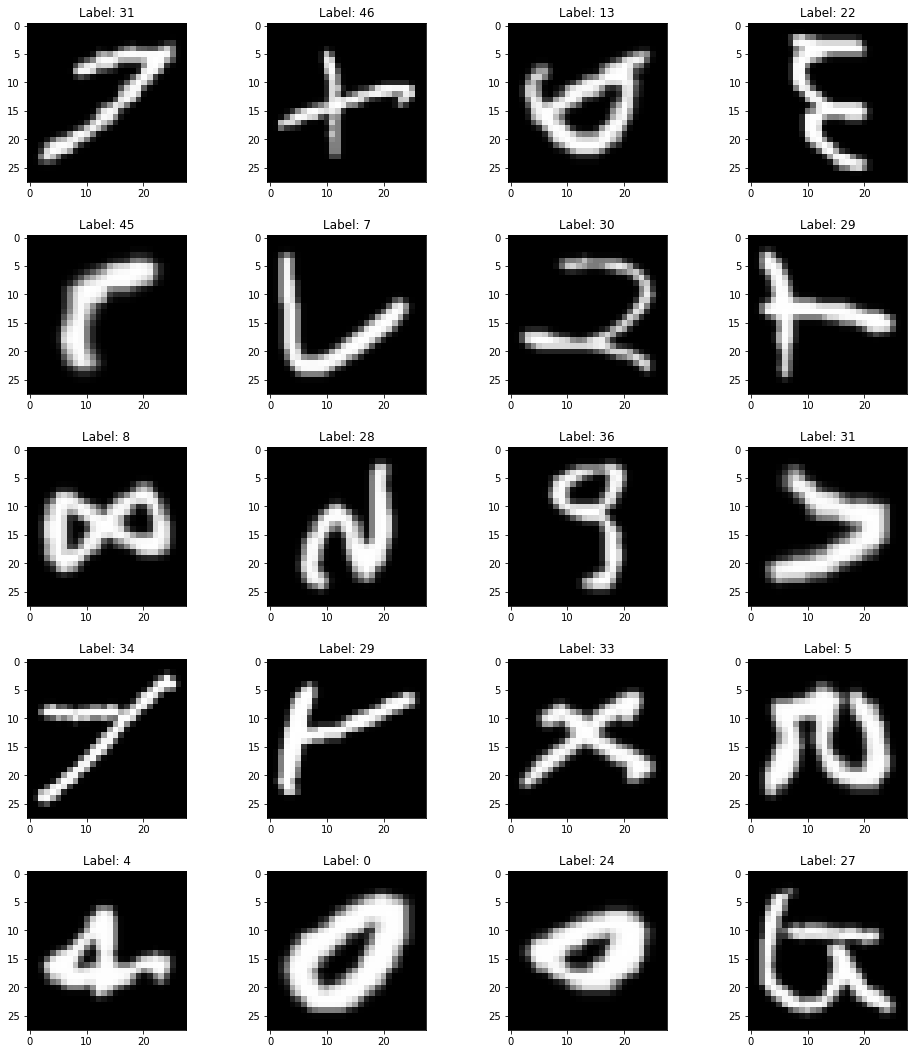

In [13]:
plot_sample_image(data_split=train_data, data_batch_size=20)

In [0]:
# Define Data Buffer Size and Batch Size
Buffer_Size = 1000
Batch_Size = 64

In [0]:
# Prepare dataset for Model Training
# Here we set the buffer size to 1000 i.e. at a time we randomly pick up 1000 reviews and fill the buffer with that.
# Then we take the data samples from dataset equal to batch size.
# Ref. https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch
# Training Data Batches
train_batches = train_data.shuffle(buffer_size=Buffer_Size).batch(Batch_Size).prefetch(tf.data.experimental.AUTOTUNE)

# Validation Data Batches
validation_batches = validation_data.shuffle(buffer_size=Buffer_Size).batch(Batch_Size).prefetch(tf.data.experimental.AUTOTUNE)

# Model Architecture

In [35]:
# ML Model Architecture
model = tf.keras.Sequential([tf.keras.layers.Input(shape=(28,28,1)),
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
                             tf.keras.layers.Dropout(rate=0.5),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(units=128, activation='relu'),
                             tf.keras.layers.Dense(units=info.features['label'].num_classes, activation='softmax')
])

# Print Model Summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)             

In [0]:
# Compile the Model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
# Training Epochs
Epochs = 10

# Validation Steps
valid_steps = 30

# Train the Model
hist = model.fit(train_batches,
                 epochs= Epochs,
                 validation_data= validation_batches,
                 validation_steps= valid_steps)

Epoch 1/10
1410/1410 [==============================] - 30s 21ms/step - loss: 0.9020 - accuracy: 0.7211 - val_loss: 0.4207 - val_accuracy: 0.8484
Epoch 2/10
1410/1410 [==============================] - 27s 19ms/step - loss: 0.4921 - accuracy: 0.8319 - val_loss: 0.3808 - val_accuracy: 0.8604
Epoch 3/10
1410/1410 [==============================] - 28s 20ms/step - loss: 0.4299 - accuracy: 0.8489 - val_loss: 0.3611 - val_accuracy: 0.8687
Epoch 4/10
1410/1410 [==============================] - 28s 20ms/step - loss: 0.3931 - accuracy: 0.8606 - val_loss: 0.3349 - val_accuracy: 0.8771
Epoch 5/10
1410/1410 [==============================] - 27s 19ms/step - loss: 0.3679 - accuracy: 0.8677 - val_loss: 0.3108 - val_accuracy: 0.8807
Epoch 6/10
1410/1410 [==============================] - 27s 19ms/step - loss: 0.3495 - accuracy: 0.8717 - val_loss: 0.3219 - val_accuracy: 0.8818
Epoch 7/10
1410/1410 [==============================] - 27s 19ms/step - loss: 0.3351 - accuracy: 0.8751 - val_loss: 0.3093 -

# Trained Model Metrics

In [0]:
# Get the Trained Model Metrics
history_dict = hist.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

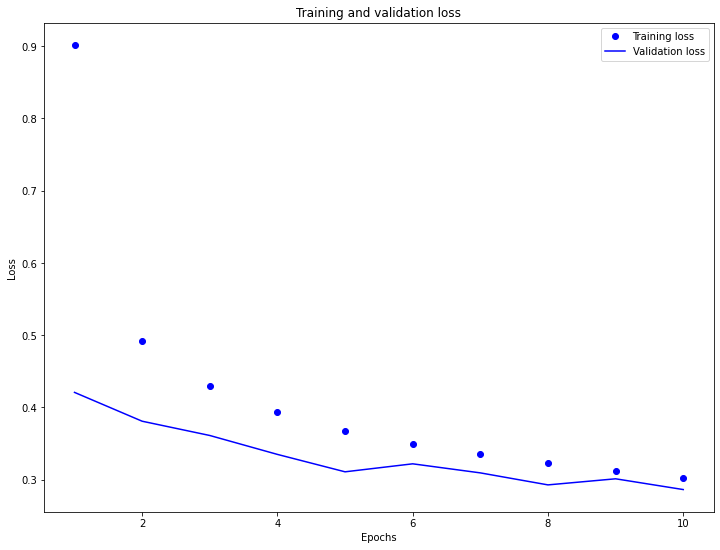

In [39]:
# Plot Training and Validation Loss
plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

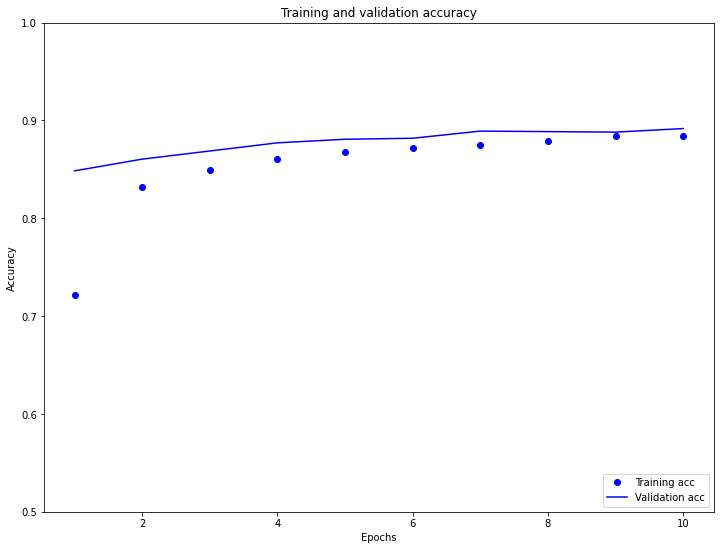

In [40]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [0]:
# Save Trained Model
model.save('emnist_cnn.h5')
model.save_weights('emnist_cnn_weights.h5')